# TP 1 (Tomas Palazzo, Noe Hsueh, Axel Fridman)

### Importacion de librerias

In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 288 kB 12.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import pandas as pd
import pickle
import time
import math
import seaborn as sns


In [4]:
import sys
#from google.colab import drive

In [5]:
#drive.mount('/content/gdrive')

### Funciones auxiliares

In [6]:
def derivadaEn1Punto1coordenada(f,Xs, x, h=0.01):
  extra = np.zeros(len(Xs))
  extra[x]=1
  return((f(Xs+extra*h)-f(Xs-extra*h))/(2*h))

In [7]:
def gradiente(f,Xs, h=0.01):
  df = np.zeros(len(Xs))
  for i in range(0, len(Xs)):
    df[i]= derivadaEn1Punto1coordenada(f,Xs, i, h)
  return(df)

In [8]:
def hessiano(f, xs, h=0.01):
    hes = np.zeros((len(xs), len(xs)))
    for i in range(0,len(xs)):
        for j in range(0, len(xs)):
            extra = np.zeros(len(xs))
            extra[i] = 1
            grad1 = derivadaEn1Punto1coordenada(f, xs+extra*h, j)
            

            grad2 = derivadaEn1Punto1coordenada(f, xs-extra*h, j)

            hes[i,j] = ((grad1-grad2)/(2*h))
           
    return (hes)

In [9]:
def seccionAurea(f, x, d, epsilon, p ):
    theta1 = (3- math.sqrt(5))/2
    theta2 = 1 - theta1
    a = 0
    s = p
    b = 2*p
    phiB = f(x+ b*d)
    phiS = f(x+ s*d)
    while(phiB<phiS):
        a = s
        s = b
        b = 2*b
        phiS = phiB
        phiB = f(x + b * d)
    u = a + theta1 * (b-a)
    v = a + theta2 * (b-a)
    phiU = f(x + u*d)
    phiV = f(x + v*d)
    while((b-a)>epsilon):
        if(phiU<phiV):
            b = v
            v = u
            u = a + theta1*(b-a)
            phiV = phiU
            phiU = f(x + u * d)
        else:
            a = u
            u = v
            v = a + theta2*(b-a)
            phiU = phiV
            phiV = f(x + v * d)
    return((u+v)/2)
            

### Funciones gradiente (normal, no conjugado)

In [10]:
def metodo_gradienteCuadraticas(A, b, x_0, max_iter, l=0):
  k = 0
  x = x_0
  d = -A @ x_0 - b
  while((k <= max_iter) and (np.linalg.norm(d) > 10e-6)):
    if l == 0:
     l = np.random.rand()
    t = l*((d.T @ d)/(d.T @ A @ d))
    x += t*d
    d = -A@x - b
    k = k +  1
  if(k==max_iter):
    print("ALCANZO MAX ITERACION!")
  return x, k 


In [119]:
def metodo_gradienteCuadraticasRotado(A, b, x_0, max_iter, l=0, theta=0):
  k = 0
  x = x_0
  rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
  d = -A @ x_0 - b
  dk2 = d
  while((k <= max_iter) and (np.linalg.norm(d) > 10e-6)):
    if l == 0:
     l = np.random.rand()
    
    t = l*((d.T @ d)/(d.T @ A @ d))
    t2 = l*((dk2.T @ dk2)/(dk2.T @ A @ dk2))
    x += t*d
    d = -A@x - b
    dk2 = (rot @ d)
    xpot = x + dk2*t2
    if(dk2@ (-d)<0): #xpot.T@A@xpot < x.T@A@x ):
        d = dk2        
    k = k +  1
  if(k==max_iter):
    print("ALCANZO MAX ITERACION!")
  return x, k 


In [11]:
def metodo_gradienteGenerico(f, x0, epsilon=0.001, maxiter=10000, n=0.4, beta=5): 
  precision = epsilon
  iter = 0
  x = x0
  xs = [x]
  
  grad = gradiente(f, x, epsilon)
  ds = [-1*grad]
  while(np.linalg.norm(grad)>precision and iter<maxiter):
      d = -1*grad
      t = busquedaArmijo(f, x, d, n, beta )
      x = x+t*d
      grad = gradiente(f, x, epsilon)
      iter = iter + 1
      xs.append(x)
      ds.append(-1*grad)
  if(iter==maxiter):
    print("ALCANZO MAX ITERACION!")
  return xs, ds , iter

### Metodos de gradiente conjugado

In [12]:
def metodo_gradienteConjugadoCuadraticas(A, b, x0, epsilon=0.001, maxiter=10000): 
  precision = epsilon
  iter = 0
  x = x0
  xs = [x]
  d = -(A@x0+b)
  ds = [d]
  while(np.linalg.norm(A@x+b)>precision and iter<maxiter):
      t = -((A@x+b).T@d) / (d.T@A@d)
      x = x+t*d
      bk = (d.T@A@(A@x+b)) / (d.T@A@d)
      d = -(A@x+b) + bk*d
      
      iter = iter + 1
      xs.append(x)
      ds.append(d)
  if(iter==maxiter):
    print("ALCANZO MAX ITERACION!")
  return xs[len(xs)-1] , iter, xs

In [13]:
def metodo_gradienteConjugadoGenerico(f, x0, epsilon=0.01, maxiter=10000): 
  precision = epsilon
  iter = 0
  x = x0
  xs = [x]
  grad = gradiente(f, x, 10**-5)
  d = -1*grad
  ds = [-1*grad]
  while(np.linalg.norm(grad)>precision and iter<maxiter):
      
      t = seccionAurea(f, x, d, 10**-5, 1)
      x = x+t*d
      if((iter+1) % len(x0) != 0):
        xant = xs[-1]
        bk = (gradiente(f,x).T @ gradiente(f,x)) / (gradiente(f,xant).T @ gradiente(f,xant))
      else:
        bk = 0
      d = -1* gradiente(f, x) + bk * d
      grad = gradiente(f, x, epsilon)
      iter = iter + 1
      xs.append(x)
      ds.append(d)
  if(iter==maxiter):
    print("ALCANZO MAX ITERACION!")
  return xs[-1] , iter, xs

### Metodos de newton

In [14]:
def newtonParaCuadraticas(A, b, x0, eps, maxIter):
    iter = 0
    x = x0
    dk = A@x0+b
    xs = [x]
    while(np.linalg.norm(dk)>eps and iter<maxIter):
        dk = np.linalg.solve(A, -(A@x+b))
        x = x + dk
        iter = iter + 1
        xs.append(x)
    return(x, iter, xs)

In [15]:
def newtonConModificacionLevenbergMarquardt(f, x0, gamma, eps = 0.01, maxIter=1000):
  iter = 0
  x = x0
  xs = [x]
  grad = gradiente(f, x, 10**-5)
  while(np.linalg.norm(grad)>eps and iter<maxIter):
    grad = gradiente(f, x, 10**-5)
    B = hessiano(f, x, 10**-5)
    u = min(np.linalg.eigvals(B))
    if(u<=0):
      B = B + (-u + gamma)*np.identity(len(B))
    dk = np.linalg.solve(B, -grad)
    tk = seccionAurea(f, x, dk, 10**-5, 1)
    x = x + dk*tk
    xs.append(x)
    iter = iter + 1
  return(x, iter, xs)

### Metodos de cuasi newton

In [16]:
def cuasiNewtonParaCuadraticas(A, b, x0, h0, eps, maxIter):
    itera = 0
    xViejo = x0
    hk = h0
    dkViejo = A@xViejo+b
    xs = [xViejo]
    while(np.linalg.norm(dkViejo)>eps and itera<maxIter):
        dkNuevo = A@xViejo+b
        dkNuevo = -hk@dkNuevo 
        tk =  (dkNuevo @ dkNuevo.T)/(dkNuevo.T@A@dkNuevo)
        xNuevo = xViejo + dkNuevo * tk
        sk = (xNuevo - xViejo)
        yk = A@sk
        hk = metodoDFP(hk, sk, yk) #cheqear si broyden es lo mejor
                                      
        itera = itera + 1
        xs.append(xNuevo)
        
        xViejo = xNuevo
        dkViejo = dkNuevo
    return(xViejo, itera, xs)

In [17]:
def broydenMala(hk, sk, yk):
    res = hk + (np.outer((sk-hk@yk),(sk-hk@yk).T)) / (yk.T@(sk-hk@yk))
    return res

In [18]:
def metodoDFP(hk, sk, yk):
    res = hk + (np.outer(sk,sk.T))/(yk.T@sk)
    res = res -  (hk@np.outer(yk,(yk.T))@hk)/(yk.T@ hk@yk)
    return res

In [19]:
def metodoBFGS(hk, sk, yk):
    res = hk + (1+(yk.T@hk@yk)/(sk.T@yk)) * (sk@sk.T)/(sk.T@yk)
    res = res - ((sk @ (yk.T) @ hk) + hk@yk@(sk.T))/(sk.T@yk)
    return res

## Cargar los archivos con las matrices generadas por nosotros previamente

In [23]:
#pick_read = open('/content/gdrive/MyDrive/UBA/invop/tps/matrices.pkl','rb')
#mats = pickle.load(pick_read)
#pick_read.close()
with open('matrices.pkl', 'rb') as f:
    F = pickle.load(f)

In [27]:
df =  pd.read_csv('infos.csv')#pd.read_csv('/content/gdrive/MyDrive/UBA/invop/tps/infos.csv')
dfResEj1 = pd.read_csv("dfResEj1.csv")

In [97]:
df["mat"] = F.values() #mats.values()

In [98]:
df.head()

,Unnamed: 0,tamanio,autovalores,autovalorMax,autovalorMin,rangoAutovalores,mat
0,0,"(2, 2)",[2.13039600e+00 1.53733452e-04],2.130396,0.000154,2.130242,"[[1.4277800159666887, 1.0015353443246913], [1...."
1,1,"(2, 2)",[5.0753714 0.10702353],5.075371,0.107024,4.968348,"[[3.1084677041108315, 2.4297225441430976], [2...."
2,2,"(2, 2)",[8.90007051 1.18815833],8.900071,1.188158,7.711912,"[[6.319120032244062, 3.6390600481153315], [3.6..."
3,3,"(2, 2)",[5.48386614e+00 3.73334809e-04],5.483866,0.000373,5.483493,"[[5.203384950030568, 1.2080343186411266], [1.2..."
4,4,"(2, 2)",[12.15494409 24.71610474],24.716105,12.154944,12.561161,"[[16.76994508395115, 6.055702662291634], [6.05..."


Ejercicio 1

```

```



NO CORRER. YA ESTAN LOS RESULTADOS

In [248]:
maxIters = 180000
zero = np.zeros(10)
unos = np.ones(10)
tamaniosPaso = [1/4, 1/2, 3/4, 0.99, 0.999, 1, 0] #0 es la version numero aleatorio entre 0 y 1
resultadosIter = []
tiempos =  []
pasos = []
rangoAutovals = []
for j in range(0, len(tamaniosPaso)):
  for i in range(0, len(mats10por10)):
    s = time.time()
    x, iter = metodo_gradienteCuadraticas(mats10por10["mat"][i+400],zero, 1*unos, maxIters, tamaniosPaso[j])
    pasos.append(tamaniosPaso[j])
    resultadosIter.append(iter)
    tiempos.append(time.time()-s)
    rangoAutovals.append(mats10por10["rangoAutovalores"][i+400])

In [249]:
res = {'rangoAutovalores': rangoAutovals, 'pasos': pasos,'iters': resultadosIter, "tiempo":tiempos}
dfResEj1 = pd.DataFrame(data=res)

DE ACA EN ADELANTE SI

In [54]:
tamaniosPaso = [1/4, 1/2, 3/4, 0.99, 0.999, 1, 0] #0 es la version numero aleatorio entre 0 y 1


Text(0, 0.5, 'Tiempo en segundos')

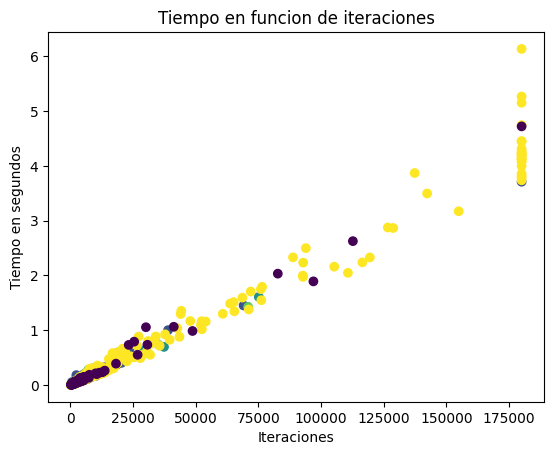

In [29]:
plt.scatter(dfResEj1['iters'], dfResEj1['tiempo'], c=dfResEj1['pasos'], label=dfResEj1['pasos'])

plt.title("Tiempo en funcion de iteraciones")
plt.xlabel("Iteraciones")
plt.ylabel("Tiempo en segundos")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


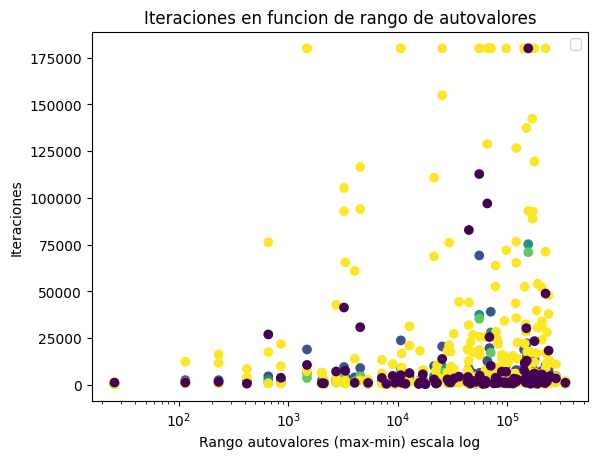

In [50]:
plt.scatter(dfResEj1['rangoAutovalores'], dfResEj1['iters'], c=dfResEj1['pasos'])#label=pd.unique(dfResEj1['pasos']))
plt.title("Iteraciones en funcion de rango de autovalores")
plt.xlabel("Rango autovalores (max-min) escala log")
plt.ylabel("Iteraciones")
plt.xscale("log")
plt.legend()
plt.show()

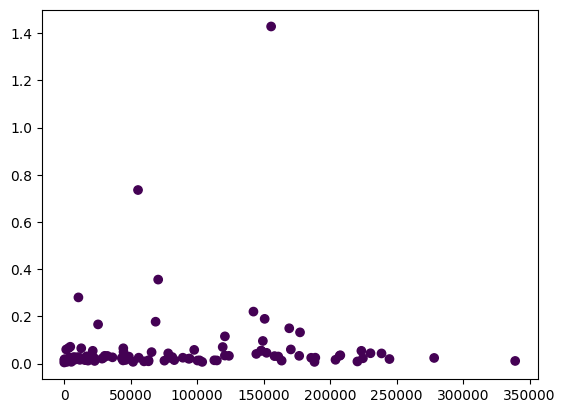

In [53]:
paso1 = dfResEj1[dfResEj1["pasos"]==0.75]
plt.scatter(paso1['rangoAutovalores'], paso1['tiempo'], c=paso1['pasos'])
#plt.xscale("log")

/tmp/ipykernel_108445/1114421266.py:1: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.




<AxesSubplot: xlabel='iters', ylabel='Density'>

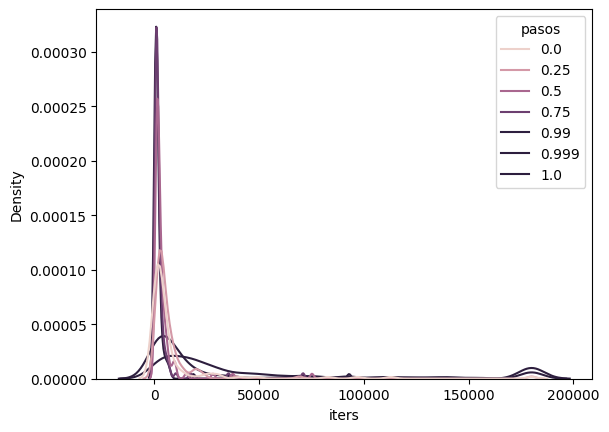

In [32]:
sns.kdeplot(data=dfResEj1, x='iters', hue='pasos', common_norm= False, bw=0.1)

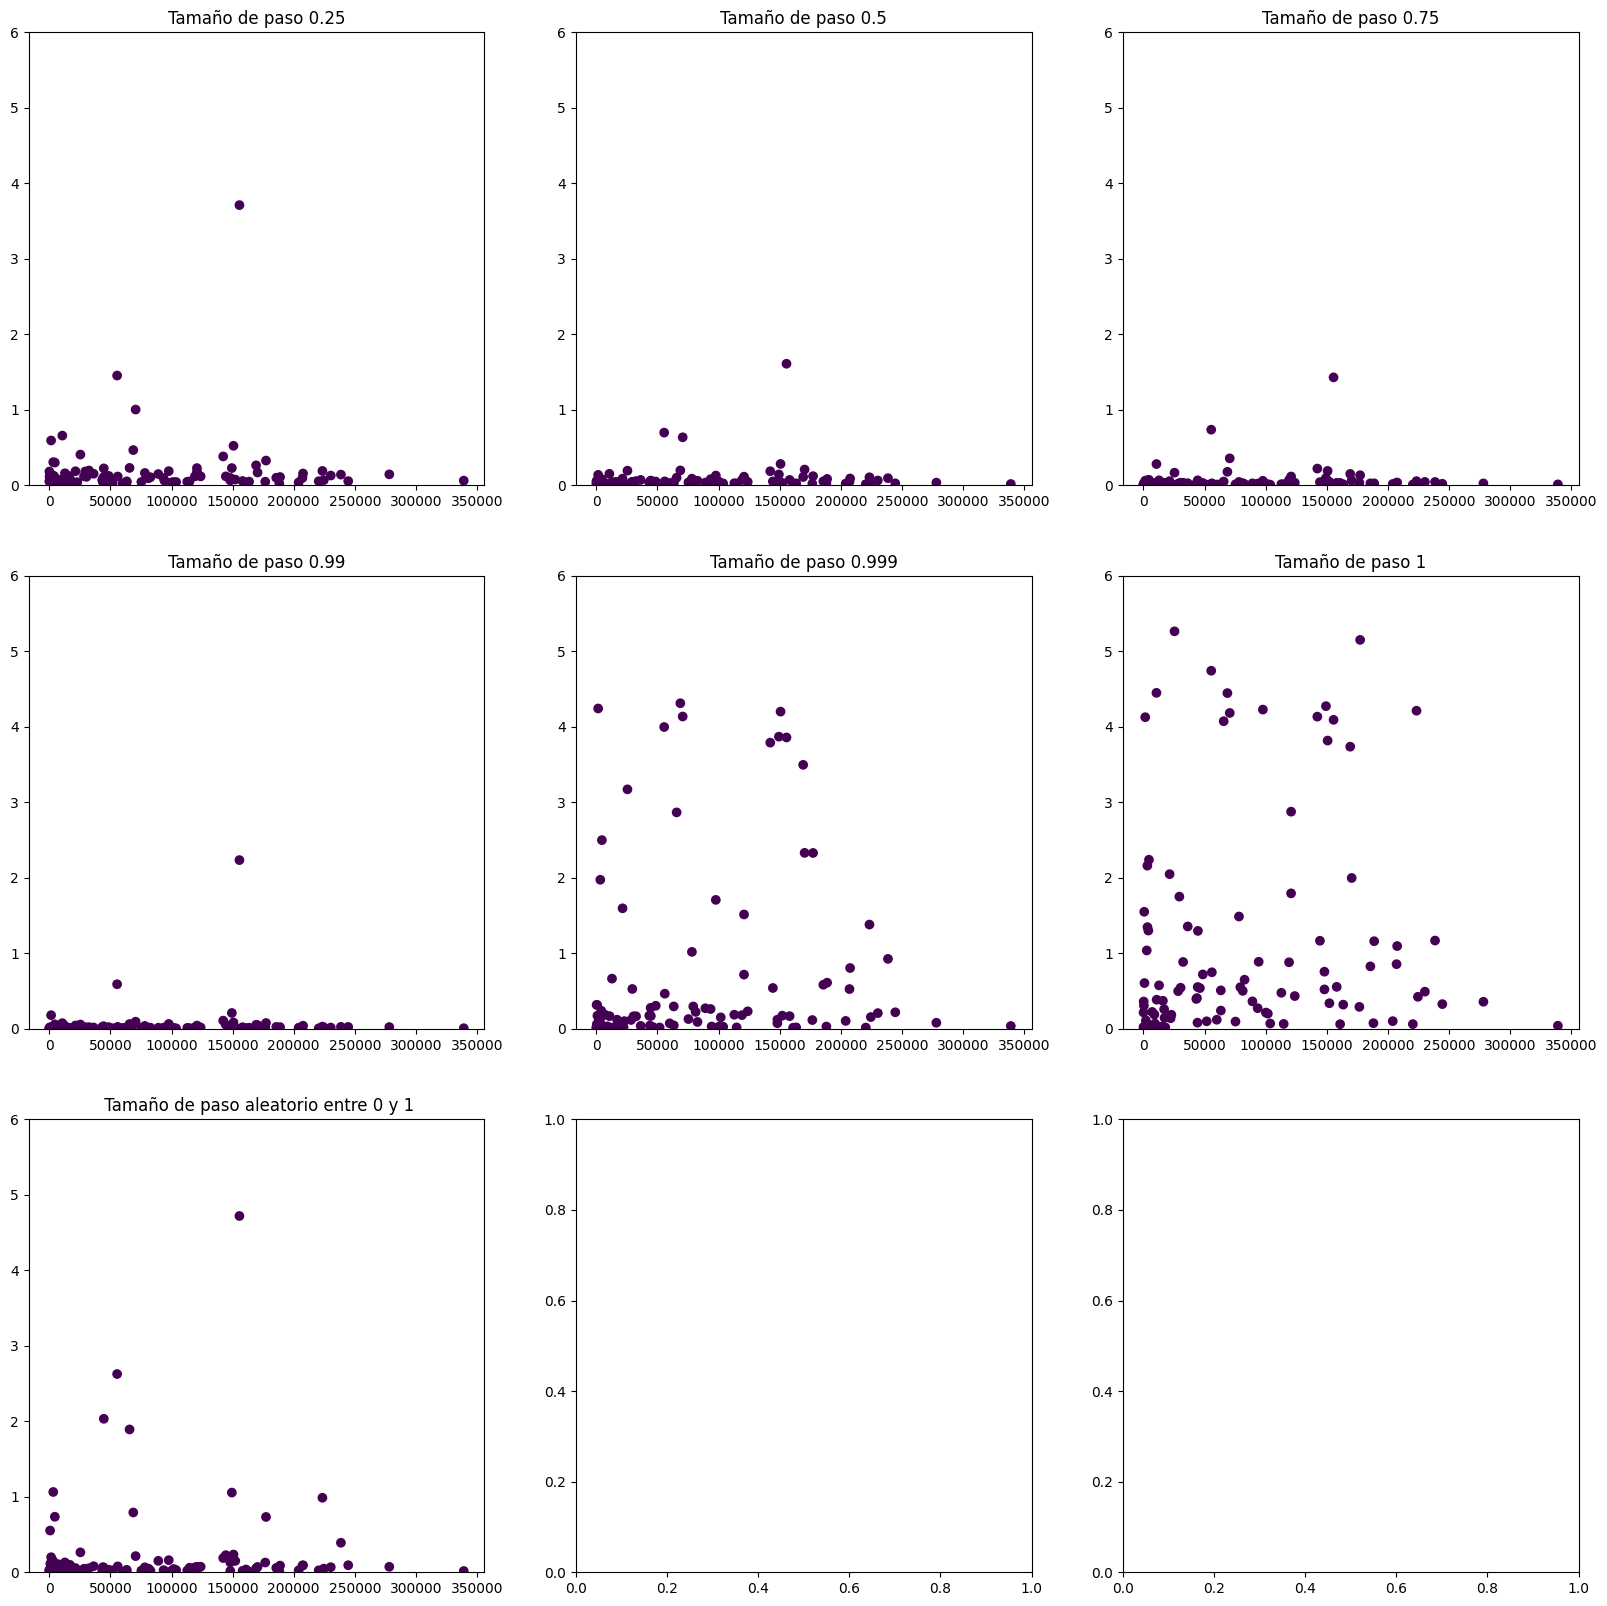

In [75]:
figure, axis = plt.subplots(3,3, figsize=(20,20))
s = 0
for i in range(0,3):
    for j in range(0, 3):
        if(s<7):
            paso1 = dfResEj1[dfResEj1["pasos"]==tamaniosPaso[s]]
            axis[i, j].scatter(paso1['rangoAutovalores'], paso1['tiempo'], c=paso1['pasos'])
            if(tamaniosPaso[s]!=0):
                axis[i, j].set_title("Tamaño de paso " + str(tamaniosPaso[s]))
            else:
                axis[i, j].set_title(" Tamaño de paso aleatorio entre 0 y 1")
            axis[i,j].set_ylim([0, 6])        

        s = s + 1
plt.show()

In [250]:
#from google.colab import files
#dfResEj1.to_csv('dfResEj1.csv') 
#files.download('dfResEj1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [99]:
df

,Unnamed: 0,tamanio,autovalores,autovalorMax,autovalorMin,rangoAutovalores,mat
0,0,"(2, 2)",[2.13039600e+00 1.53733452e-04],2.130396e+00,0.000154,2.130242e+00,"[[1.4277800159666887, 1.0015353443246913], [1...."
1,1,"(2, 2)",[5.0753714 0.10702353],5.075371e+00,0.107024,4.968348e+00,"[[3.1084677041108315, 2.4297225441430976], [2...."
2,2,"(2, 2)",[8.90007051 1.18815833],8.900071e+00,1.188158,7.711912e+00,"[[6.319120032244062, 3.6390600481153315], [3.6..."
3,3,"(2, 2)",[5.48386614e+00 3.73334809e-04],5.483866e+00,0.000373,5.483493e+00,"[[5.203384950030568, 1.2080343186411266], [1.2..."
4,4,"(2, 2)",[12.15494409 24.71610474],2.471610e+01,12.154944,1.256116e+01,"[[16.76994508395115, 6.055702662291634], [6.05..."
...,...,...,...,...,...,...,...
895,895,"(200, 200)",[9.21345276e+07 6.00533605e+05 5.70291990e+05 ...,9.213453e+07,11.661051,9.213452e+07,"[[597581.2955310631, 438044.93462902965, 46668..."
896,896,"(200, 200)",[9.49249818e+07 6.12618378e+05 5.93736134e+05 ...,9.492498e+07,0.081413,9.492498e+07,"[[647650.3247842679, 448159.1950441256, 470908..."
897,897,"(200, 200)",[9.59743697e+07 6.15718613e+05 5.93635176e+05 ...,9.597437e+07,0.182582,9.597437e+07,"[[632222.2896321212, 464755.69765387033, 52072..."
898,898,"(200, 200)",[9.81884878e+07 6.19073300e+05 6.06222160e+05 ...,9.818849e+07,2.015392,9.818849e+07,"[[635386.0147657621, 490770.8197573107, 483793..."


In [100]:
df2por2 = df[df["tamanio"]=="(2, 2)"]

In [127]:
# 1 b
metodo_gradienteCuadraticasRotado(df2por2.mat[1],np.zeros(2), 78*np.ones(2), 10000,1, -1/3* 3.1415926)

(array([-3.12392324,  1.34597083]), 10001)

In [101]:
df2por2

,Unnamed: 0,tamanio,autovalores,autovalorMax,autovalorMin,rangoAutovalores,mat
0,0,"(2, 2)",[2.13039600e+00 1.53733452e-04],2.130396,0.000154,2.130242,"[[1.4277800159666887, 1.0015353443246913], [1...."
1,1,"(2, 2)",[5.0753714 0.10702353],5.075371,0.107024,4.968348,"[[3.1084677041108315, 2.4297225441430976], [2...."
2,2,"(2, 2)",[8.90007051 1.18815833],8.900071,1.188158,7.711912,"[[6.319120032244062, 3.6390600481153315], [3.6..."
3,3,"(2, 2)",[5.48386614e+00 3.73334809e-04],5.483866,0.000373,5.483493,"[[5.203384950030568, 1.2080343186411266], [1.2..."
4,4,"(2, 2)",[12.15494409 24.71610474],24.716105,12.154944,12.561161,"[[16.76994508395115, 6.055702662291634], [6.05..."
...,...,...,...,...,...,...,...
95,95,"(2, 2)",[3.06881620e+03 5.76129888e-02],3068.816199,0.057613,3068.758586,"[[2155.140255282995, 1403.2274111435431], [140..."
96,96,"(2, 2)",[ 1024.35566548 21827.18907902],21827.189079,1024.355665,20802.833414,"[[9152.754968160652, 10150.01780237416], [1015..."
97,97,"(2, 2)",[12229.83526839 991.28691634],12229.835268,991.286916,11238.548352,"[[10268.024679869395, 4266.05231700815], [4266..."
98,98,"(2, 2)",[ 431.5786369 1714.76080462],1714.760805,431.578637,1283.182168,"[[466.29553739818283, 208.18944366709425], [20..."


In [156]:
maxIters = 2001
zero = np.zeros(2)
unos = np.ones(2)
tamaniosRot = np.pi * np.array([-1/3, -1/4, -1/6, 0, 1/6, 1/4, 1/3])

resultadosIter1b = []
tiempos1b =  []
rots1b = []
rangoAutovals1b = []

for j in range(0, len(tamaniosRot)):
  for i in range(0, len(df2por2)):
    s = time.time()
    x, iters = metodo_gradienteCuadraticasRotado(df2por2["mat"][i],zero, 1*unos, maxIters, 0.75, tamaniosRot[j])
    rots1b.append(tamaniosRot[j])
    resultadosIter1b.append(iters)
    tiempos1b.append(time.time()-s)
    rangoAutovals1b.append(df2por2["rangoAutovalores"][i])

In [157]:
res1b = {'rangoAutovalores': rangoAutovals1b, 'rotacion': rots1b,'iters': resultadosIter1b, "tiempo":tiempos1b}
dfResEj1b = pd.DataFrame(data=res1b)

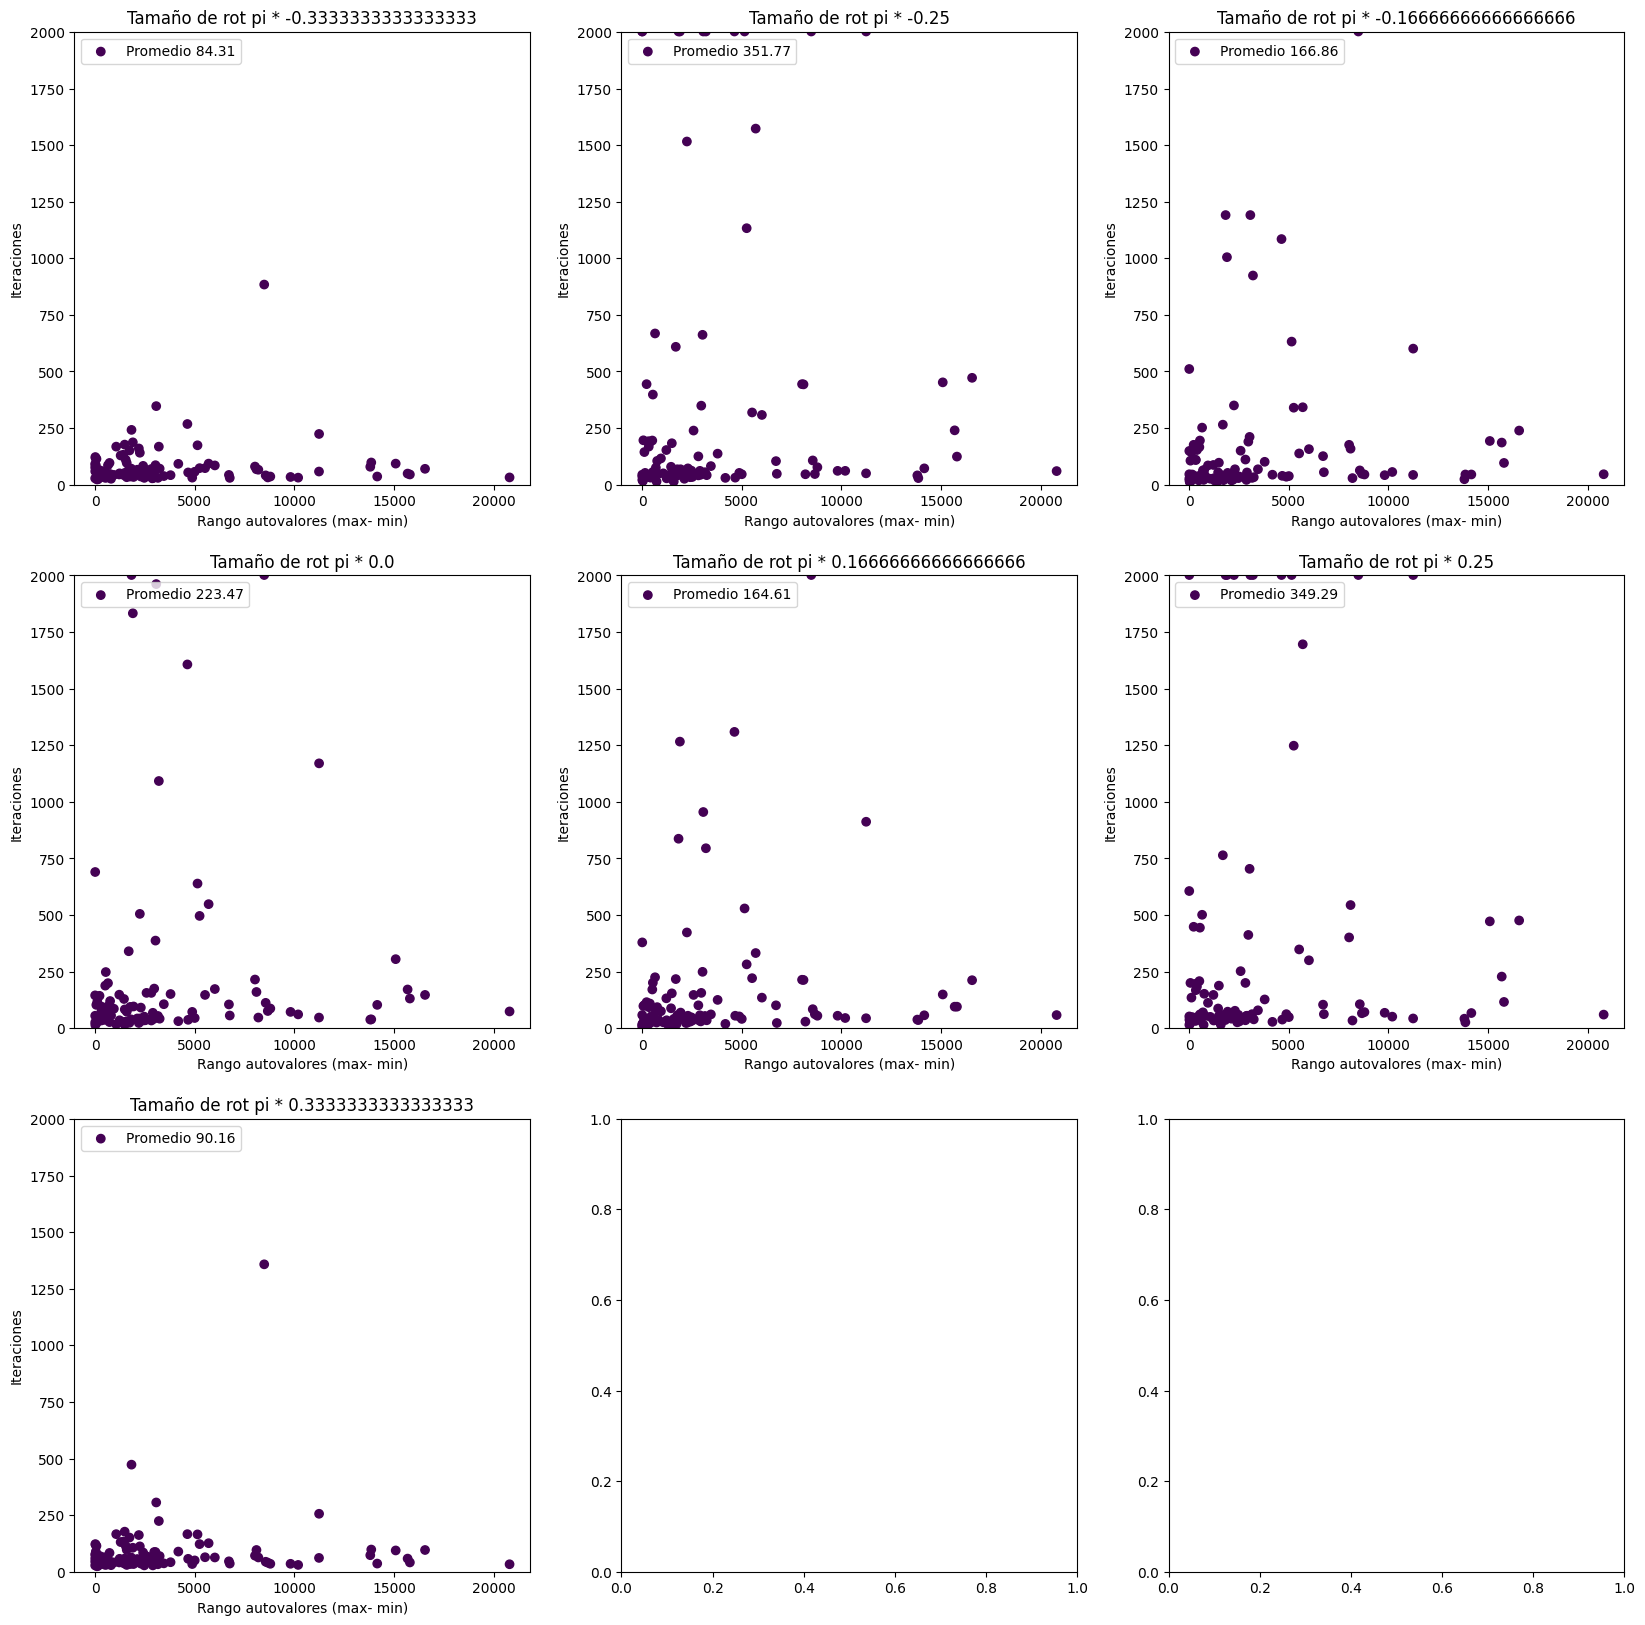

In [173]:
tamaniosRot = np.pi * np.array([-1/3, -1/4, -1/6, 0, 1/6, 1/4, 1/3])
figure, axis = plt.subplots(3,3, figsize=(20,20))
s = 0
for i in range(0,3):
    for j in range(0, 3):
        if(s<7):
            paso1 = dfResEj1b[dfResEj1b["rotacion"]==tamaniosRot[s]]
            axis[i,j].set_ylim([0, 2001])        
            axis[i, j].scatter(paso1['rangoAutovalores'], paso1['iters'], c=paso1['rotacion'], label="Promedio "+str(np.mean(paso1['iters'])))
            axis[i, j].set_xlabel("Rango autovalores (max- min)")
            axis[i, j].set_ylabel("Iteraciones")
            axis[i, j].legend(loc="upper left")
            axis[i, j].set_title("Tamaño de rot pi * " + str(tamaniosRot[s]/np.pi))      
        s = s + 1
plt.show()

In [159]:
dfResEj1b.to_csv('dfResEj1b.csv')